Start

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Read data

In [210]:
bnkrpt = 'Bankrupt?'

df = pd.read_csv("data.csv")
df.head(30)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,1,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,1,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,1,0.030801


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

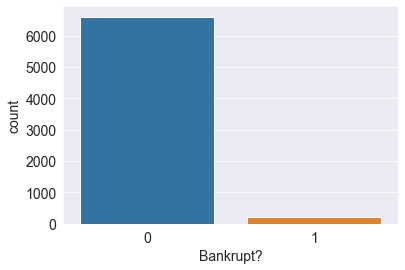

In [212]:
plt.figure()
sns.countplot(x = bnkrpt,data = df)
plt.show()

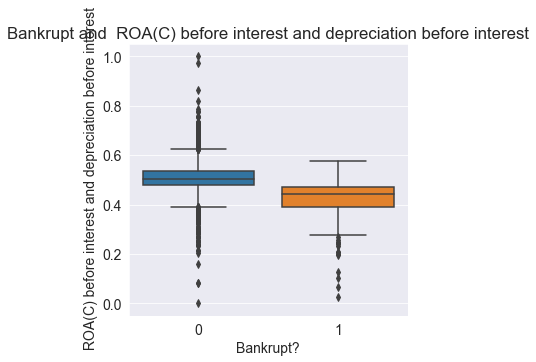

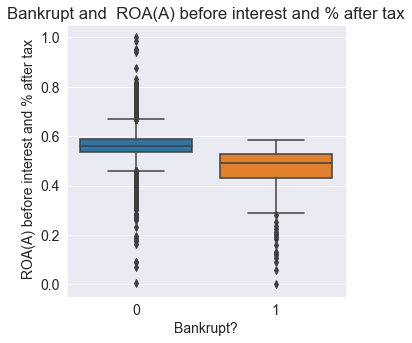

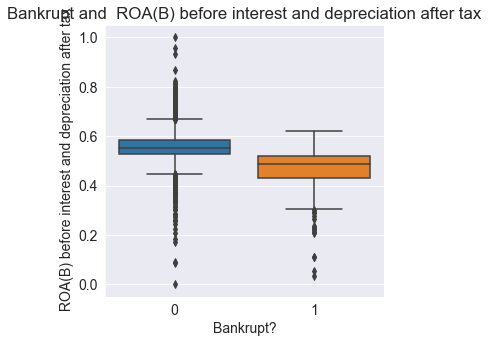

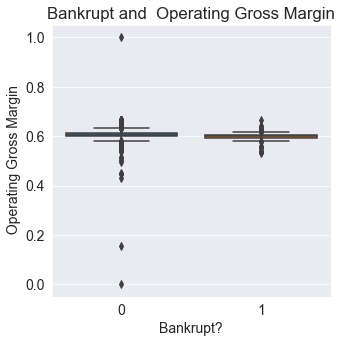

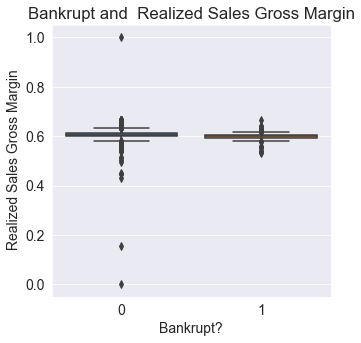

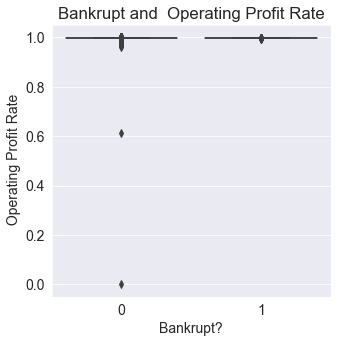

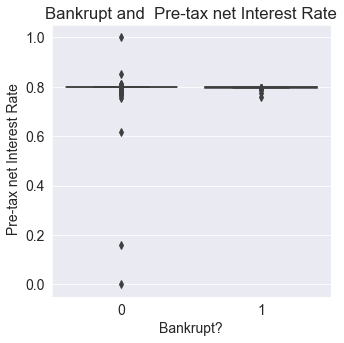

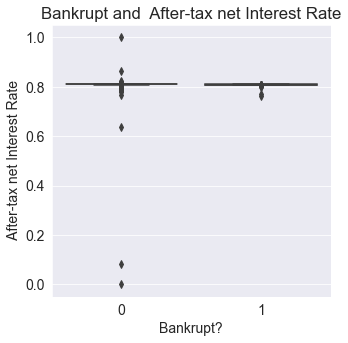

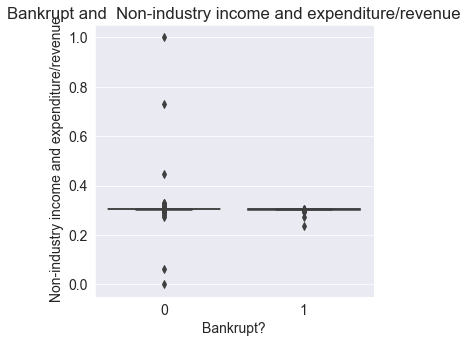

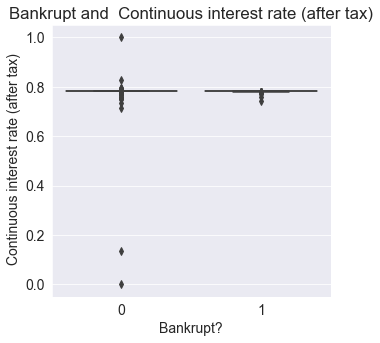

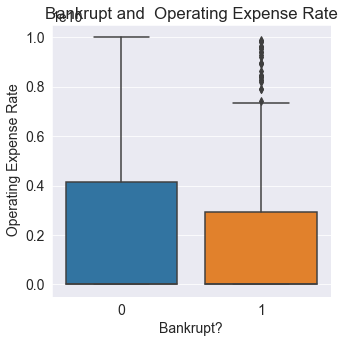

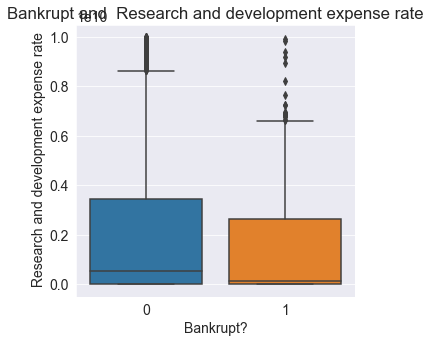

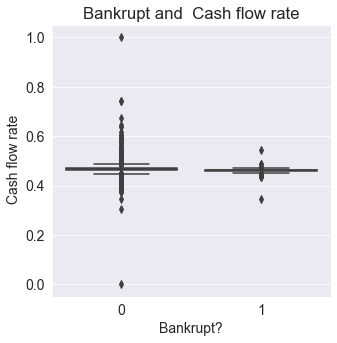

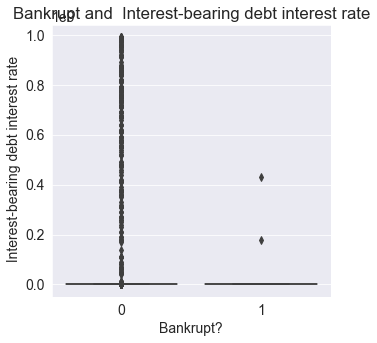

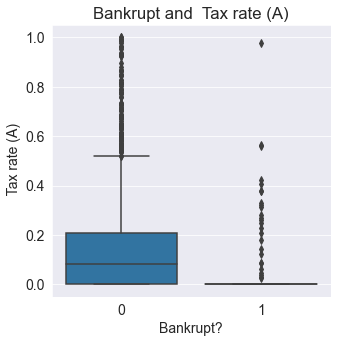

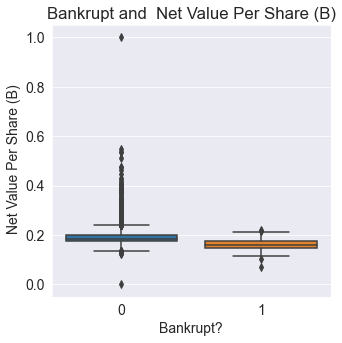

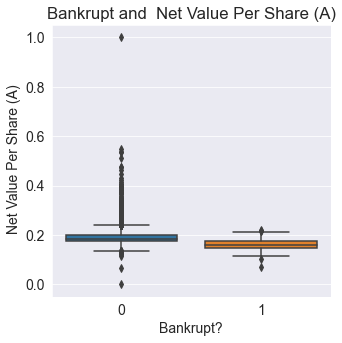

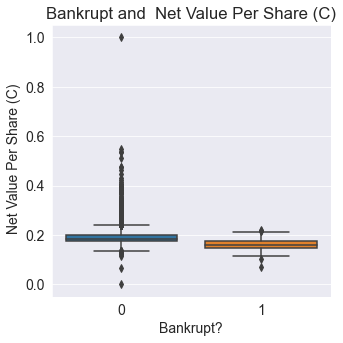

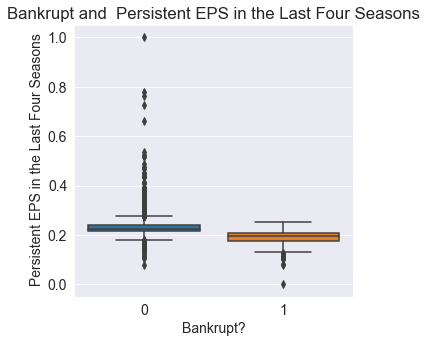

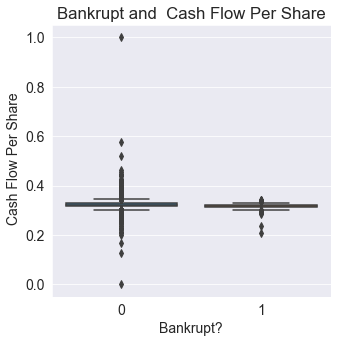

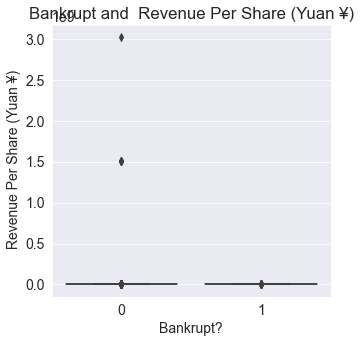

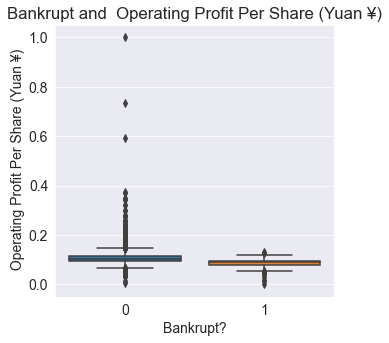

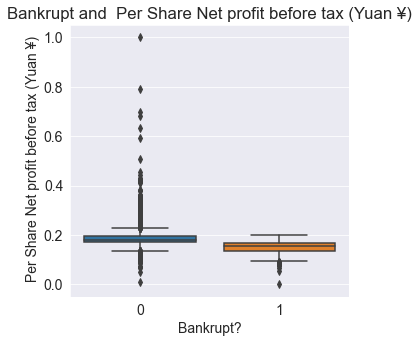

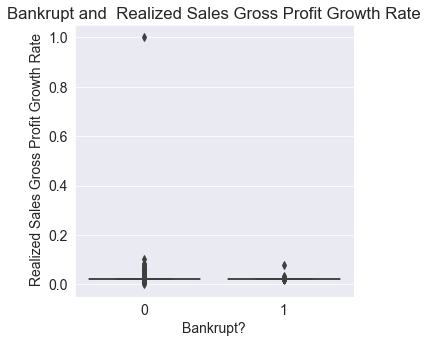

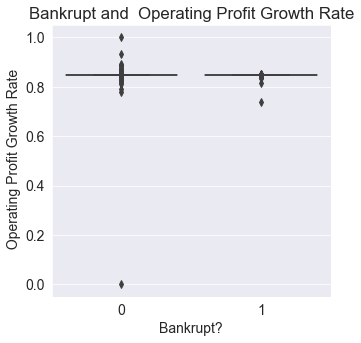

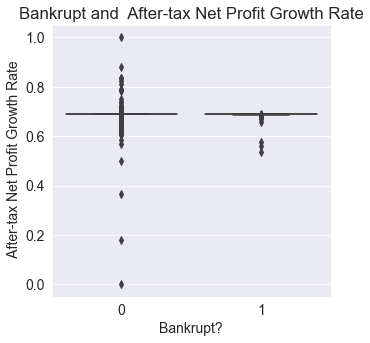

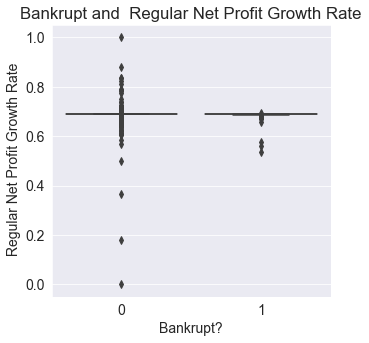

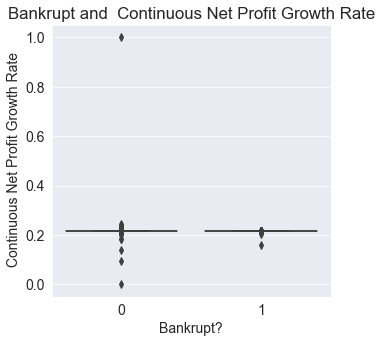

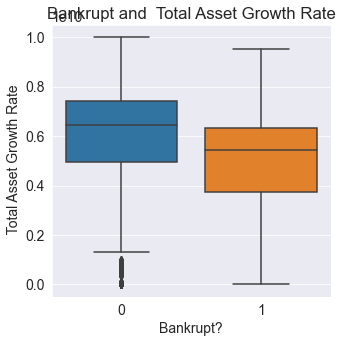

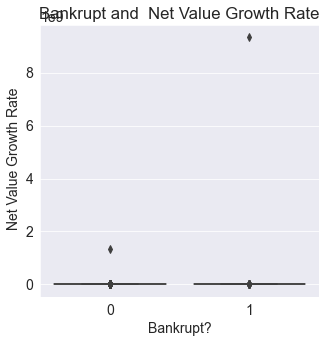

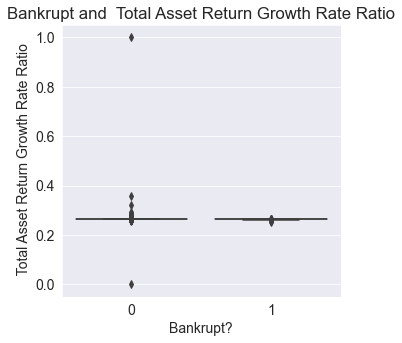

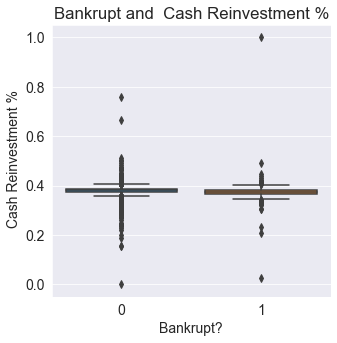

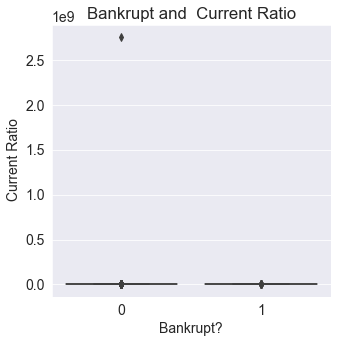

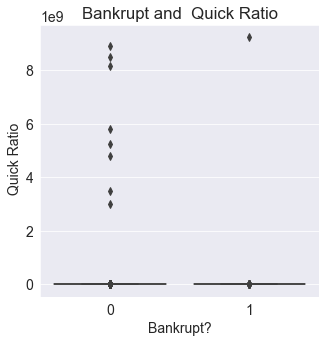

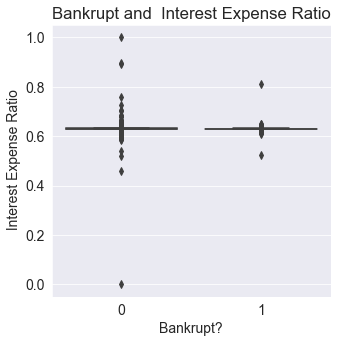

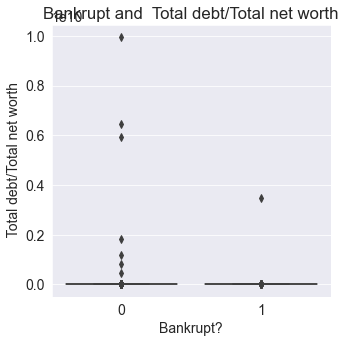

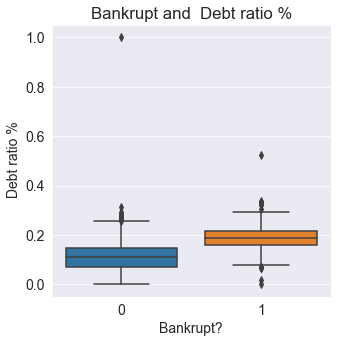

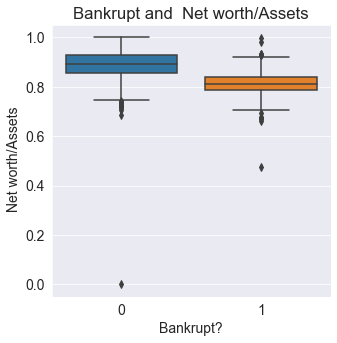

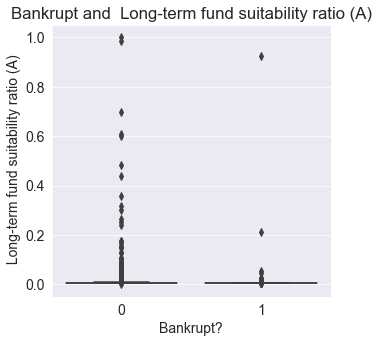

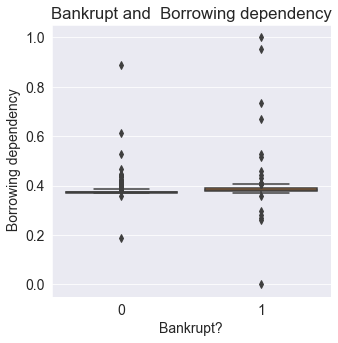

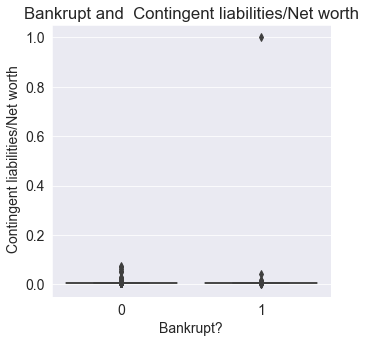

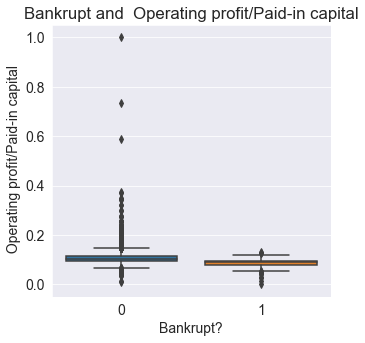

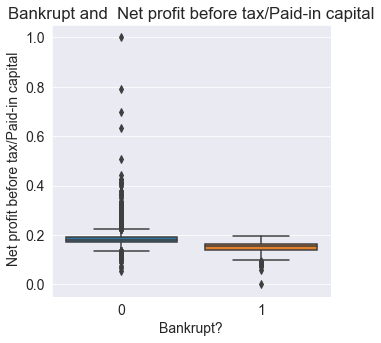

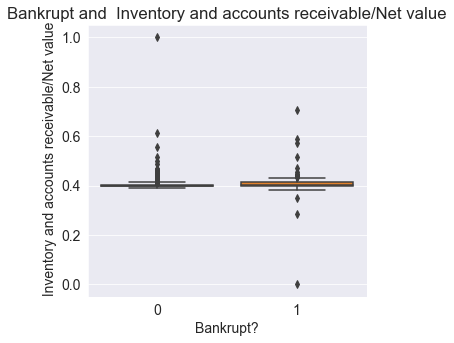

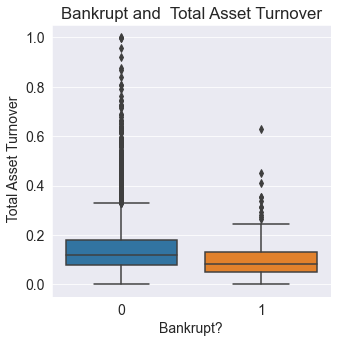

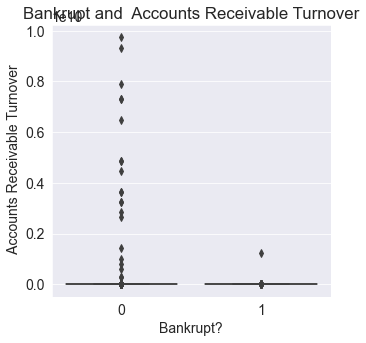

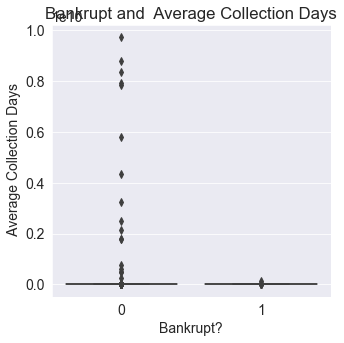

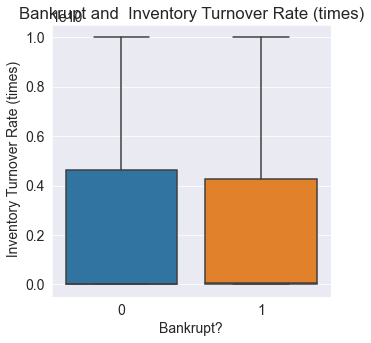

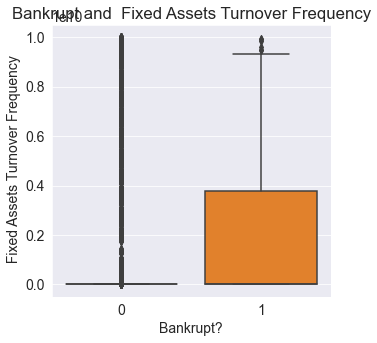

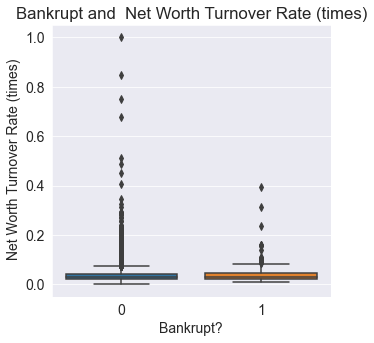

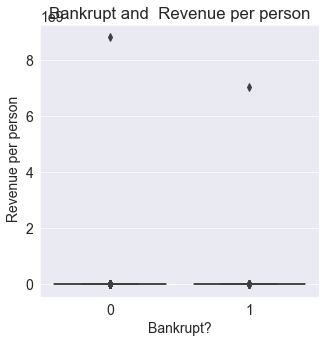

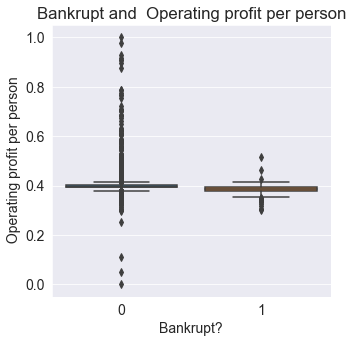

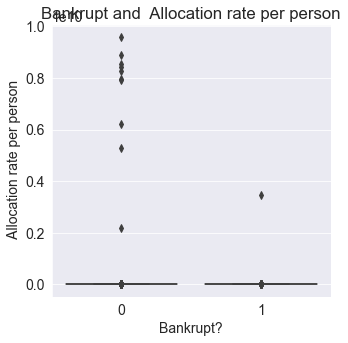

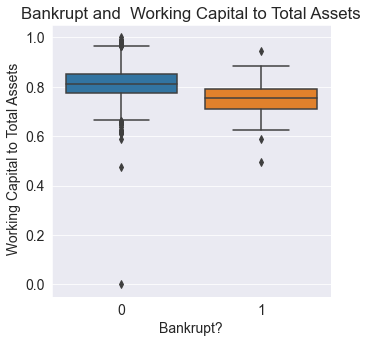

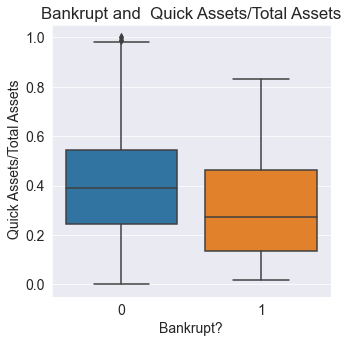

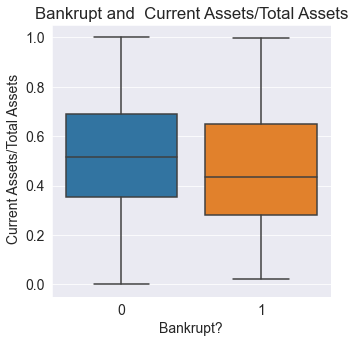

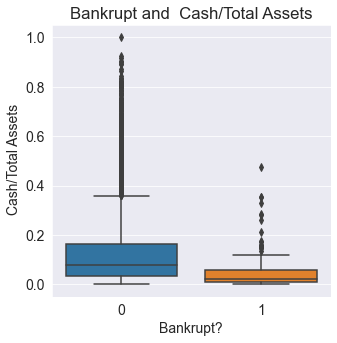

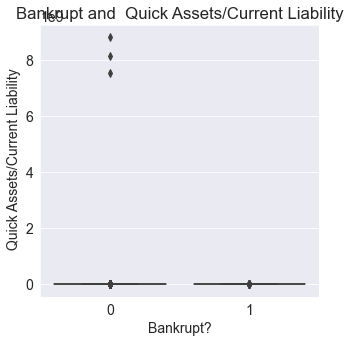

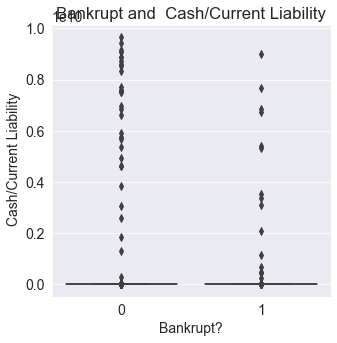

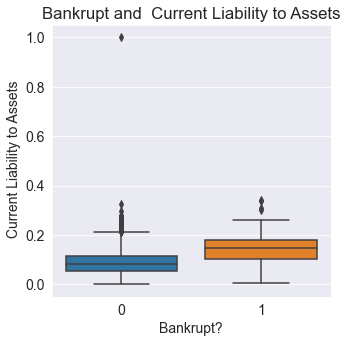

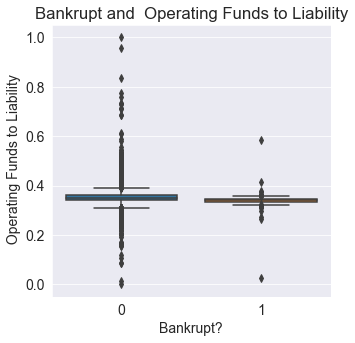

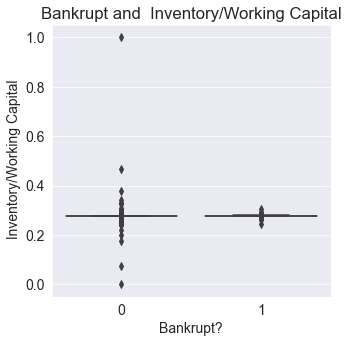

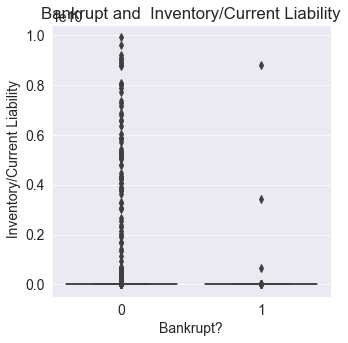

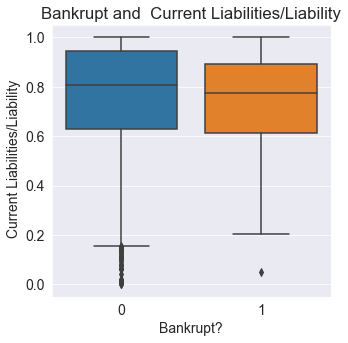

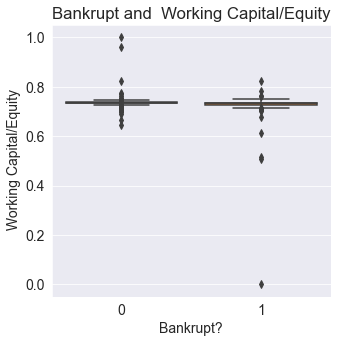

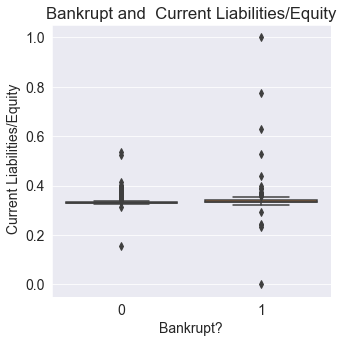

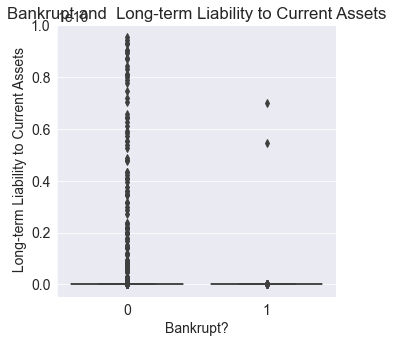

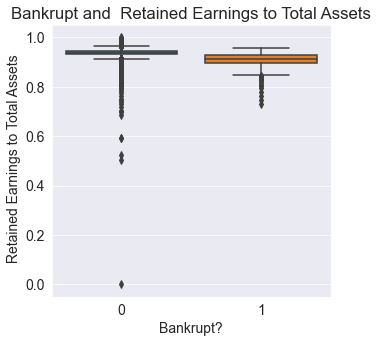

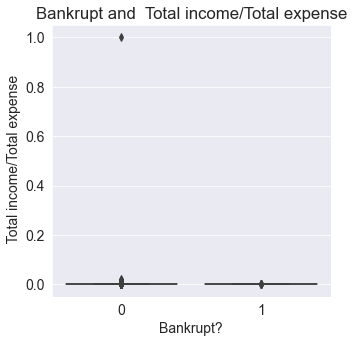

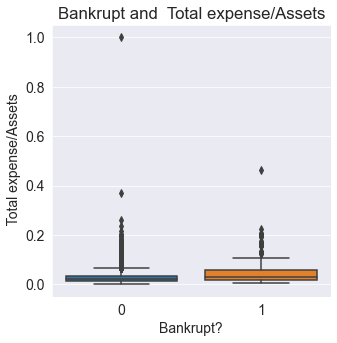

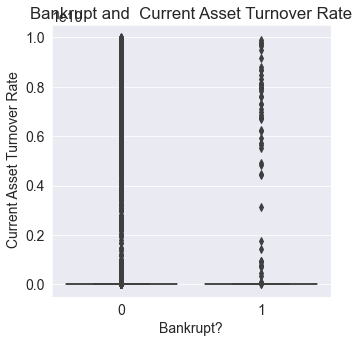

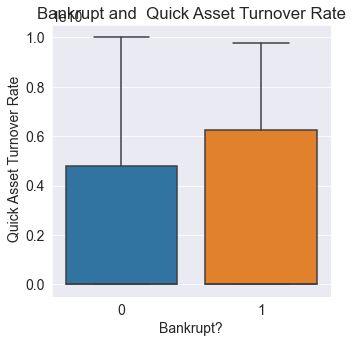

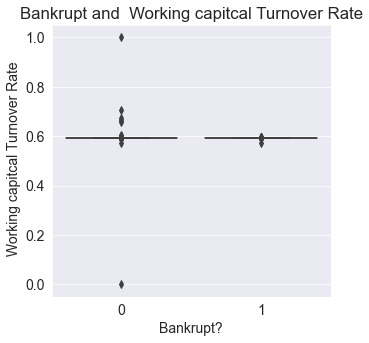

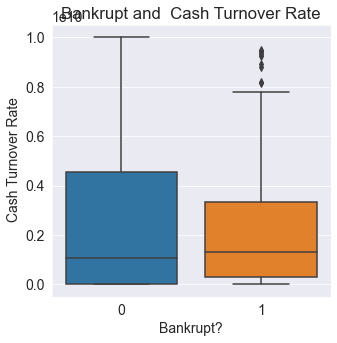

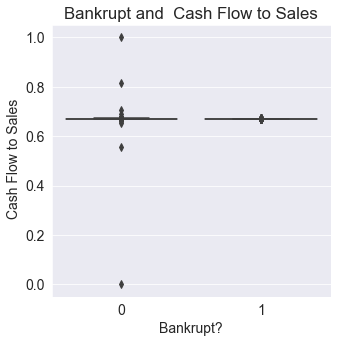

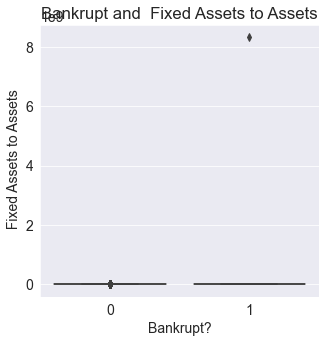

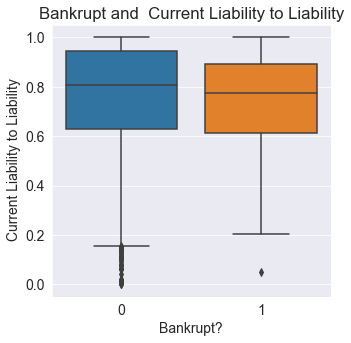

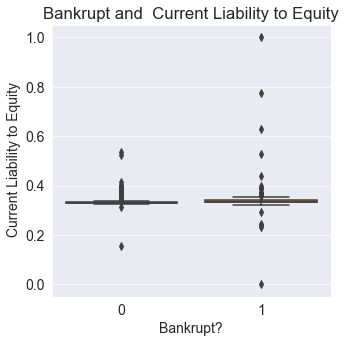

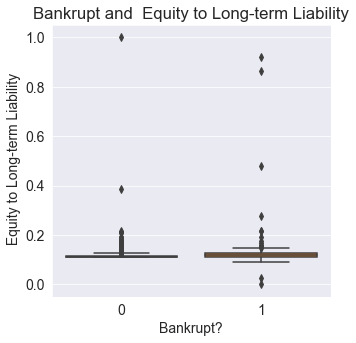

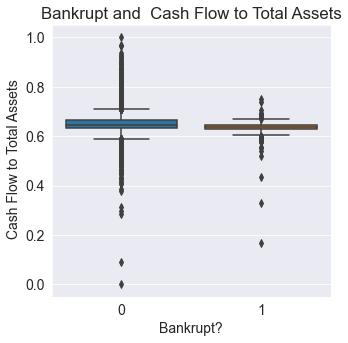

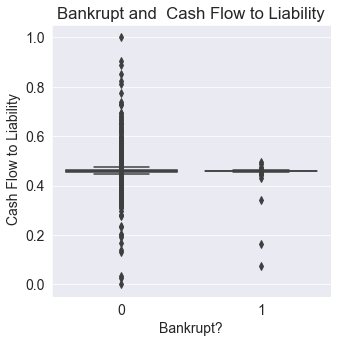

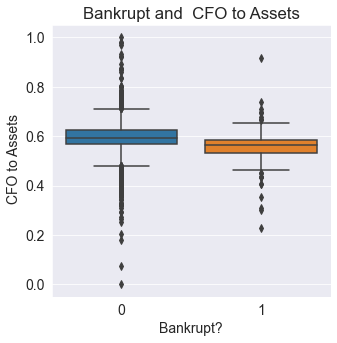

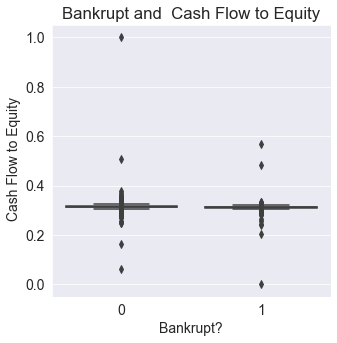

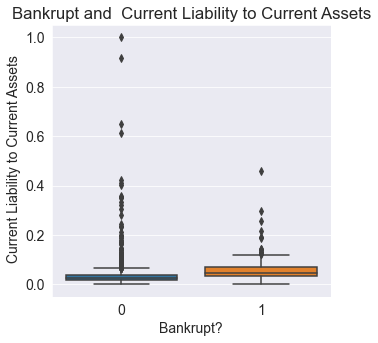

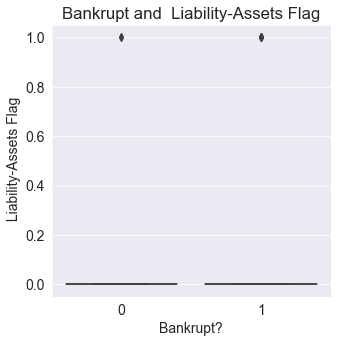

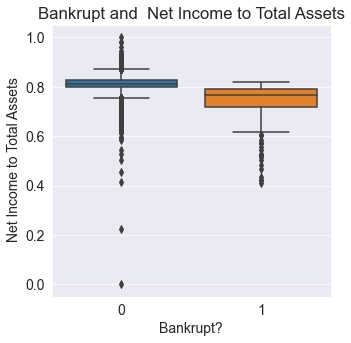

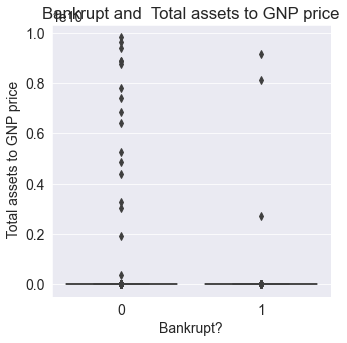

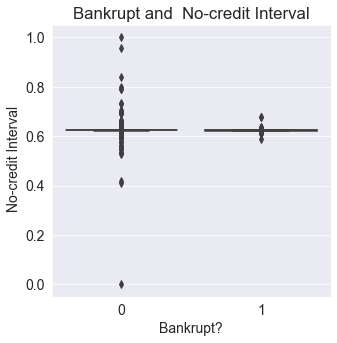

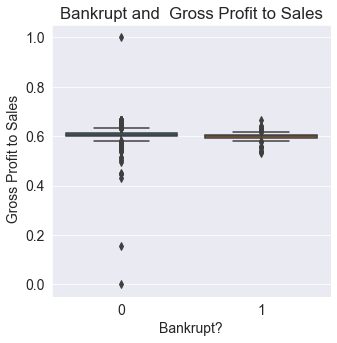

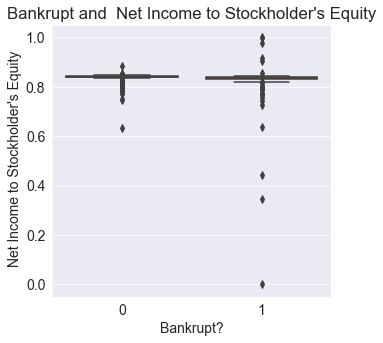

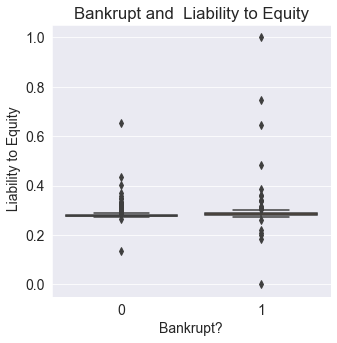

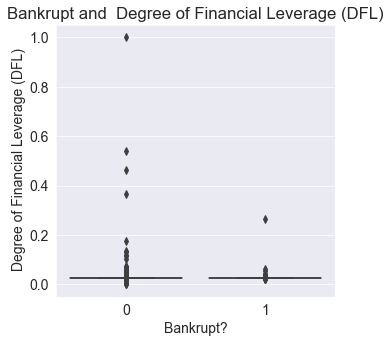

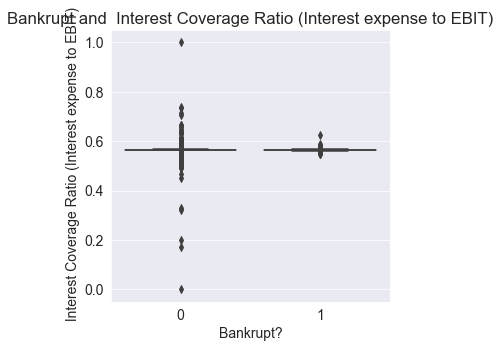

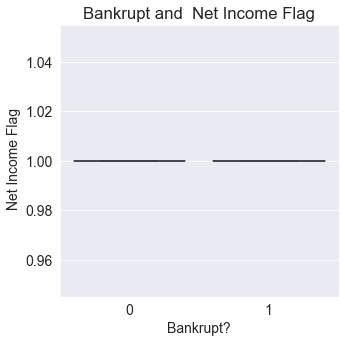

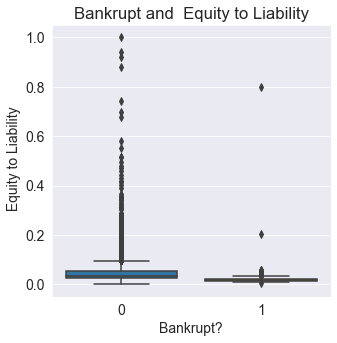

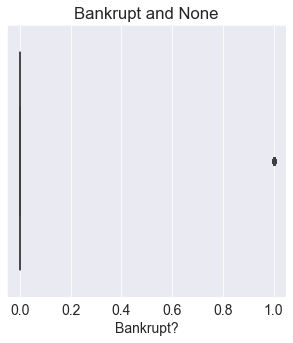

In [213]:
types = df.columns.tolist()
types.remove(bnkrpt)
types.append(None)

for i in types:
    figure, axes = plt.subplots(figsize = (5,5))
    sns.boxplot(x=bnkrpt, y=i, data=df, ax = axes)
    axes.set_title(f"Bankrupt and {i}")
    plt.show()
    print("\n\n")

types.remove(None)

In [214]:
def remove_outlier(feature, feature_name, data):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    IQR = q3 - q1

    data = data.drop(data[(data[feature_name] > q3 + 1.5 * IQR) |
                                   (data[feature_name] < q1 - 1.5 * IQR)]
                           .index)
    return data

for col in df:
    clean_df = remove_outlier(df[col], str(col), df)

clean_df.shape

(6270, 96)

In [215]:
X = df.drop([bnkrpt],axis=1)
y = df[bnkrpt].values

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info = vif_info[vif_info['VIF'] > 5]
vif_info.sort_values('VIF', ascending=False)

print(vif_info.sort_values('VIF', ascending=False))
col = vif_info['Column']

for i in col:
    if "Current Liabilities/Liability" in i or "Debt ratio %" in i or "Total Asset Turnover" in i:
        continue
    del X[i]

             VIF                                             Column
63  1.885180e+11                      Current Liabilities/Liability
76  5.084590e+10                     Current Liability to Liability
59  1.649093e+10                        Current Liability to Assets
37  1.531503e+10                                   Net worth/Assets
55  8.608678e+09                        Current Assets/Total Assets
77  7.818213e+09                        Current Liability to Equity
53  5.659886e+09                    Working Capital to Total Assets
65  5.232308e+09                         Current Liabilities/Equity
36  3.168298e+09                                       Debt ratio %
5   2.925408e+08                              Operating Profit Rate
3   6.052054e+07                             Operating Gross Margin
6   4.953474e+07                          Pre-tax net Interest Rate
88  4.773425e+07                              Gross Profit to Sales
8   6.944743e+06        Non-industry income and 

C:\Users\Zver\PycharmProjects\pythonProject3\venv\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [216]:
smote = SMOTE(random_state=123)
X_sm , y_sm = smote.fit_resample(X,y)

scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

x_train , x_test , y_train ,y_test = train_test_split(X_sm,y_sm,test_size= 0.33, random_state=43)

C:\Users\Zver\PycharmProjects\pythonProject3\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


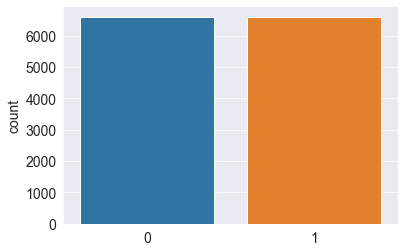

In [217]:
plt.figure()
sns.countplot(y_sm)
plt.show()

{'algorithm': 'auto', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2173
           1       0.94      1.00      0.97      2183

    accuracy                           0.97      4356
   macro avg       0.97      0.97      0.97      4356
weighted avg       0.97      0.97      0.97      4356



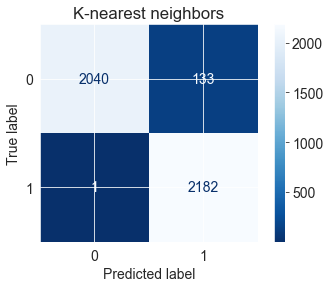

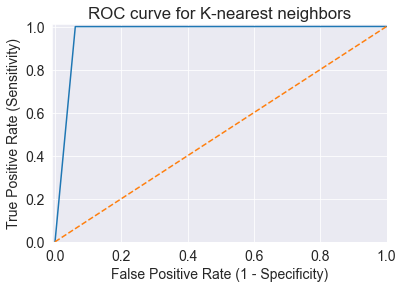

In [218]:
def report(fit, method_name):
    y_predicted = fit.predict(x_test)
    report = metrics.classification_report(y_test, y_predicted)

    print(report)
    f, axis = plt.subplots()
    axis.set_title(f'''{method_name}''')
    ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, values_format=None, cmap=plt.cm.Blues_r, ax=axis)

    y_probability = fit.predict_proba(x_test)[:, 1]

    fp_rate, tp_rate, thr = metrics.roc_curve(y_test, y_probability)

    f, axis = plt.subplots()
    axis.plot(fp_rate, tp_rate)
    axis.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.title(f'ROC curve for {method_name}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

knn_fit = KNeighborsClassifier()
knn_fit = GridSearchCV(knn_fit, {'n_neighbors' : [1,3,5,7],
                                 'algorithm':['auto','kd_tree','brute']}).fit(x_train, y_train)
print(knn_fit.best_params_)
knn_fit = knn_fit.best_estimator_
report(knn_fit, "K-nearest neighbors")

{'C': 2, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2173
           1       0.87      0.91      0.89      2183

    accuracy                           0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356



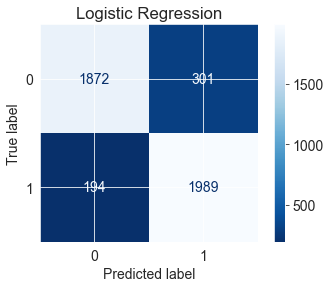

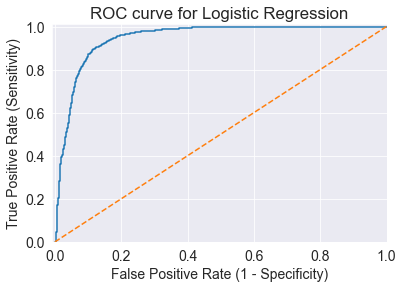

In [219]:
lgr_fit = LogisticRegression(max_iter=10000)
lgr_fit = GridSearchCV(lgr_fit, {'C': [1,2,5,7,10],
                                 'solver':['lbfgs','liblinear', 'saga']}).fit(x_train, y_train)
print(lgr_fit.best_params_)
lgr_fit = lgr_fit.best_estimator_
report(lgr_fit, "Logistic Regression")

{'C': 20, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2173
           1       0.95      0.99      0.97      2183

    accuracy                           0.97      4356
   macro avg       0.97      0.97      0.97      4356
weighted avg       0.97      0.97      0.97      4356



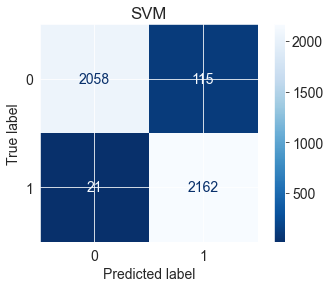

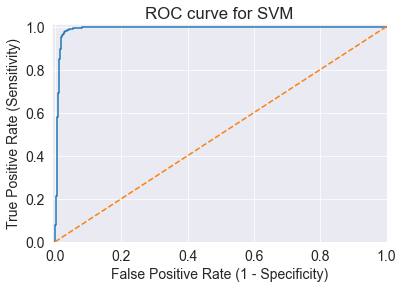

In [220]:
svm_fit = SVC(probability=True)
svm_fit = GridSearchCV(svm_fit, {'C': [1,5,10,15,20],
                                  'kernel': ['rbf','linear', 'poly', 'sigmoid']}).fit(x_train,y_train)
print(svm_fit.best_params_)
svm_fit = svm_fit.best_estimator_
report(svm_fit,"SVM")

{'criterion': 'gini', 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2173
           1       0.96      0.99      0.97      2183

    accuracy                           0.97      4356
   macro avg       0.97      0.97      0.97      4356
weighted avg       0.97      0.97      0.97      4356



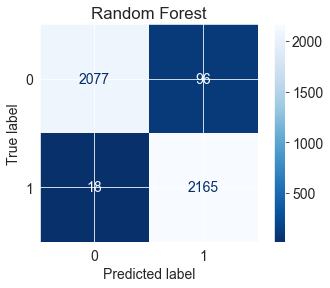

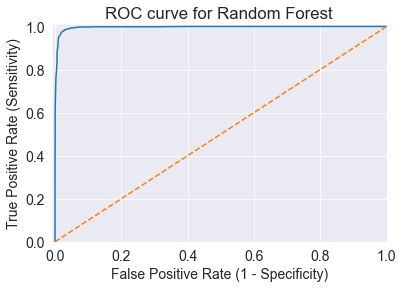

In [221]:
forest_fit = RandomForestClassifier()
forest_fit = GridSearchCV(forest_fit, {'n_estimators': [1,5,10,20,30,50],
                                       'criterion':['gini','entropy']}).fit(x_train,y_train)
print(forest_fit.best_params_)
forest_fit = forest_fit.best_estimator_
report(forest_fit, "Random Forest")

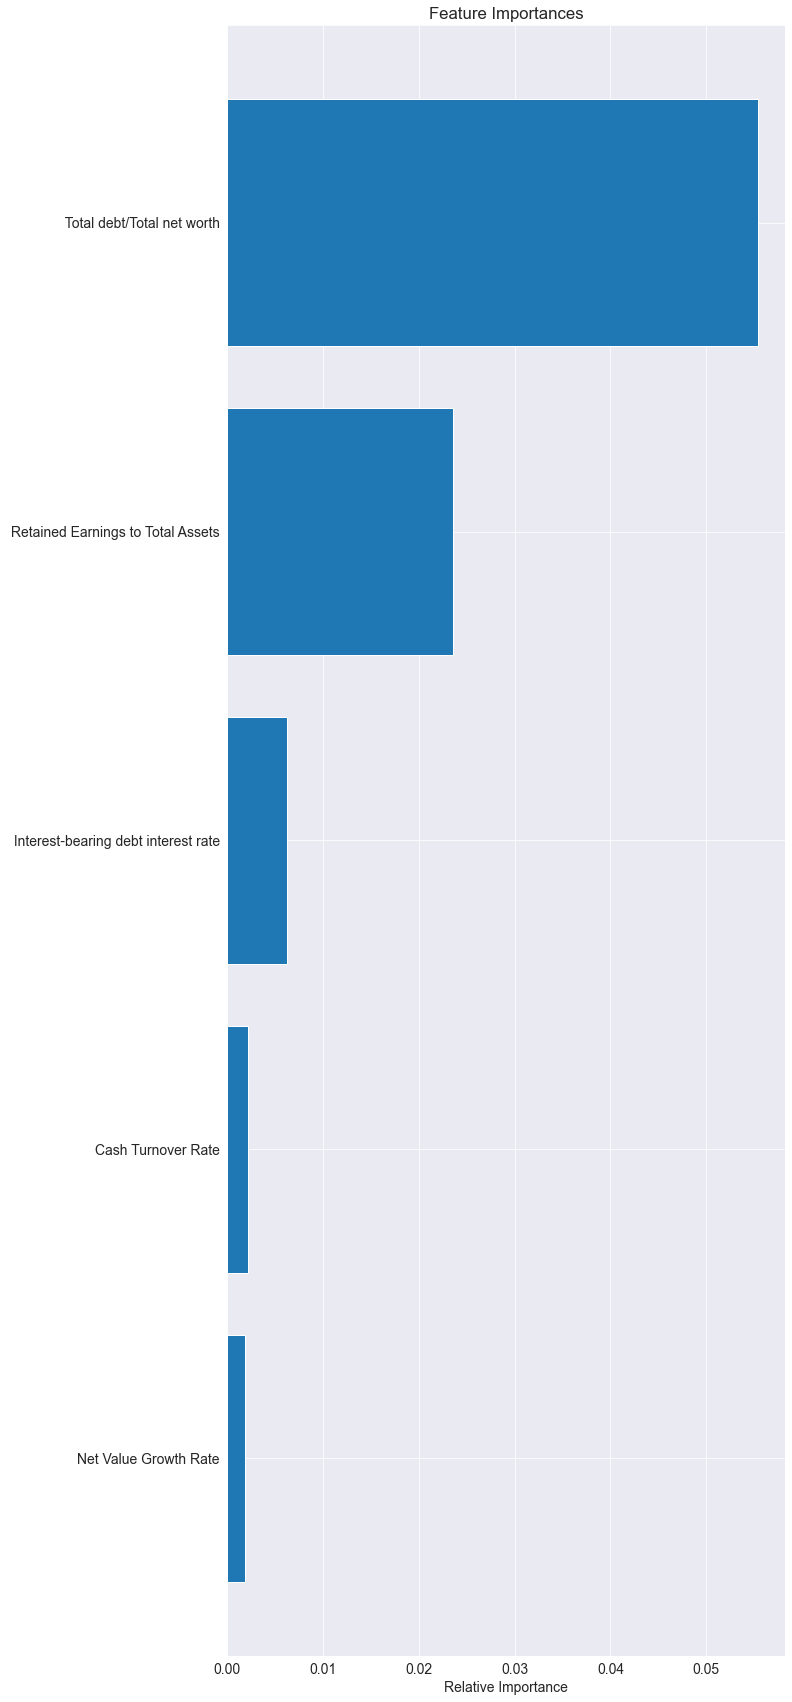

In [222]:
features = X.columns
importances = result.importances_mean
indices = result.importances_mean.argsort()

# customized number
num_features = 5

plt.figure(figsize=(10,30))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

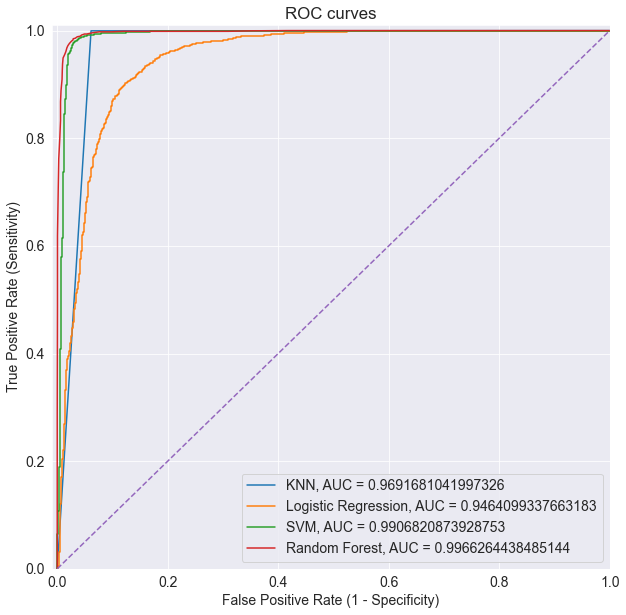

In [223]:
fits = [{"name":"KNN", "fit":knn_fit},
        {"name":"Logistic Regression", "fit":lgr_fit},
        {"name":"SVM", "fit":svm_fit},
        {"name":"Random Forest", "fit":forest_fit}]



fpr_arr=[]
tpr_arr=[]

fig, ax = plt.subplots(figsize=(10,10))

for i in fits:
    y_prob = i["fit"].predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    auc = metrics.auc(fpr, tpr)
    fpr_arr.append(fpr)
    tpr_arr.append(tpr)
    ax.plot(fpr, tpr, label=f'{i["name"]}, AUC = {auc}')

ax.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.title('ROC curves')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)